# Models

In [ ]:
from text_analysis import lowercase_text_fields, remove_named_entities, pos_tagging, tokenize_regex, remove_stopwords, emotion_analysis, remove_punctuation, analyze_text_errors, analyze_readability
import pandas as pd 


df = pd.read_json("without_assessment_updated.jsonl", lines=True)
articles = df["Text"].to_list()
titles = df["Title"].to_list()
data = df[["Title", "Text"]].to_dict(orient="records")

features = []
data_lowercase = lowercase_text_fields(data)

for article in data_lowercase:
    print(article["Title"])
    title = article["Title"]
    text = article["Text"]

    # POS tagging
    pos_feats = pos_tagging(text)

    # Emotion analysis (on preprocessed text)
    text_wo_punct = remove_punctuation(text)
    tokens = tokenize_regex(text_wo_punct)
    tokens_wo_sw = remove_stopwords(tokens)
    clean_text = " ".join(tokens_wo_sw)
    emotion_feats = emotion_analysis(clean_text)

    # Text errors (really slow)
    ner_cleaned_text = remove_named_entities(text)
    spell_err = analyze_text_errors(ner_cleaned_text)

    # Readability
    reading_feats = analyze_readability(text)

    row = {
        "Title": title,
        "noun_pct": pos_feats[0],
        "verb_pct": pos_feats[1],
        "adj_pct": pos_feats[2],
        "adv_pct": pos_feats[3],
        "pron_pct": pos_feats[4],
        "adj_noun_ratio": pos_feats[5],
        "adv_verb_ratio": pos_feats[6],
        "spelling_error_rate": spell_err,
        #"reading_ease": reading_feats[0],
        #"kincaid_grade": reading_feats[1],
        "gunning_fog": reading_feats[2],
        #"smog": reading_feats[3],
        "automated_readability": reading_feats[4]
        #"grammar_error_rate": grammar_err
    }

    emotions = ['anger', 'fear', 'disgust', 'sadness', 'joy', 'surprise', 'trust', 'anticipation', 'positive', 'negative']
    for i, emotion in enumerate(emotions):
        row[f"emotion_{emotion}"] = emotion_feats[i]

    features.append(row)

features_df = pd.DataFrame(features)
labels_df = pd.read_csv("group31_stage1.csv", sep=";")
labels_df["label"] = labels_df["real_news"].replace({"yes": 1, "no": 0})
adjusted_index = labels_df["index"] - 1
features_df.loc[adjusted_index, "Label"] = labels_df["label"].values
print(features_df.head)

[nltk_data] Downloading package punkt_tab to /Users/ida/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ida/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ida/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


is it clouds, shipping or a volcano? scientists present potential reasons for record heat
world's forests failed to curb 2023 climate emissions, study finds
alarmists threaten ‘worldwide societal breakdown’ from climate crisis
corporate media relying on very recent history to claim global warming – but with a longer view of time, it’s clear that human-caused climate change is a hoax
media, stop blaming 'climate change' for hurricanes
poilievre’s indifference on ‘climate change’ triggers the media
bill gates plans to chop down billions of trees to ‘radically address climate change’
groundbreaking study confirms human emissions have ‘zero impact’ on climate change
nolte: scientists prove man-made global warming is a hoax
climate models have accurately predicted global heating, study finds
climate simulations are mostly accurate, study finds
last decade was earth’s hottest ever as co2 levels reach an 800,000-year high, says un report
climate change: the hoax that costs us $4 billion a day

/var/folders/nx/3dtsq4dd3bj446q4qgr8b1gh0000gn/T/ipykernel_36419/2263744915.py:61: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df["label"] = labels_df["real_news"].replace({"yes": 1, "no": 0})


In [2]:
from sklearn.model_selection import train_test_split

X = features_df.drop('Label', axis=1)
X = X.drop('Title', axis=1)
y = features_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def evaluation(model, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = model.predict(X_train)
        y_true = y_train
        dataset_type = "Training"
    else:
        pred = model.predict(X_test)
        y_true = y_test
        dataset_type = "Test"

    # Metrics
    acc = accuracy_score(y_true, pred)
    prec = precision_score(y_true, pred)
    rec = recall_score(y_true, pred)
    f1 = f1_score(y_true, pred)

    print(f"{dataset_type} Result:\n" + "="*50)
    print(f"Accuracy       : {acc:.4f}")
    print(f"Precision      : {prec:.4f}")
    print(f"Recall         : {rec:.4f}")
    print(f"F1 Score       : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"{dataset_type} Confusion Matrix")
    plt.grid(False)
    plt.show()

## Random forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=6, min_samples_split=15, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=20, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=8, max_features=log2, min_samples_leaf=10, min_samples_split=15, n_estimators

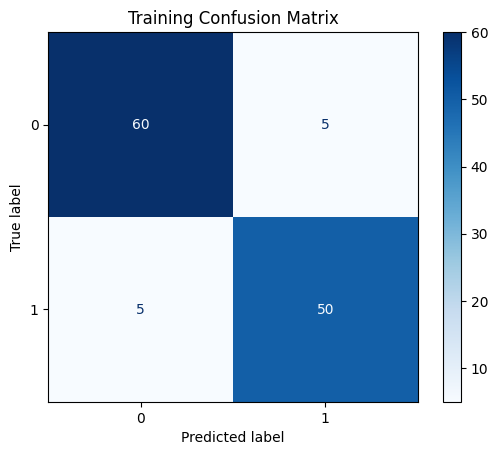

Test Result:
Accuracy       : 0.7000
Precision      : 0.6667
Recall         : 0.5000
F1 Score       : 0.5714

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.83      0.77        18
         1.0       0.67      0.50      0.57        12

    accuracy                           0.70        30
   macro avg       0.69      0.67      0.67        30
weighted avg       0.70      0.70      0.69        30



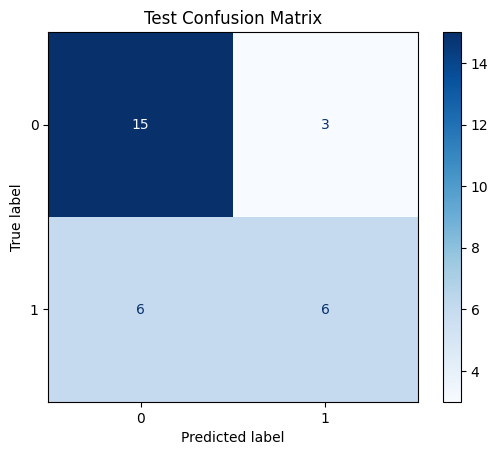

Test Result:
Accuracy       : 0.8733
Precision      : 0.8750
Recall         : 0.8358
F1 Score       : 0.8550

Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.90      0.89        83
         1.0       0.88      0.84      0.85        67

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



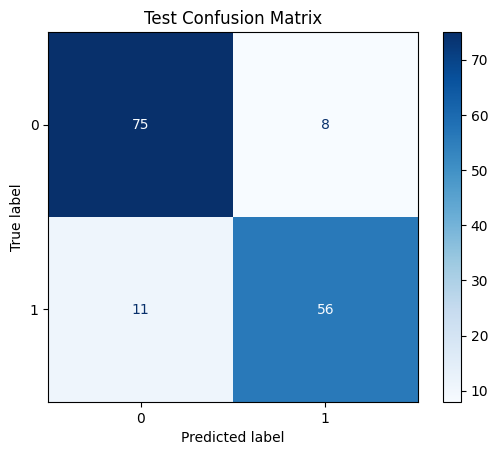

In [4]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid
param_distributions = {
    'n_estimators': [200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 8, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [5, 8, 6, 10],
    'bootstrap': [True]
}


random_forest_model = RandomForestClassifier(random_state=0)

# RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=random_forest_model,
                                   param_distributions=param_distributions,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

# Randomized parameter search
random_search.fit(X_train, y_train)

# Best parameters
best_params = random_search.best_params_
print("Best Parameters found: ", best_params)

# Evaluation on the model with the best parameters
best_model = random_search.best_estimator_
evaluation(best_model, X_train, y_train, X_test, y_test, train=True)
evaluation(best_model, X_train, y_train, X_test, y_test, train=False)
evaluation(best_model, X_train, y_train, X, y, train=False) # whole set


results to csv

In [5]:
predictions = best_model.predict(X)

# Example: Convert numeric predictions to "yes"/"no"
label_map = {1: "yes", 0: "no"}
predicted_labels = [label_map[pred] for pred in predictions]

# Create a DataFrame (include index if needed)
submission_df = pd.DataFrame({
    'index': range(1, len(predicted_labels) + 1),  # If your original index starts at 1
    'real_news': predicted_labels
})

# Save to CSV
submission_df.to_csv("predictions.csv", index=False)


## XGBoost

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_estimators=150, reg_alpha=1, reg_lambda=1.5, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, learning_rate=0.05, max_depth=3, n_e

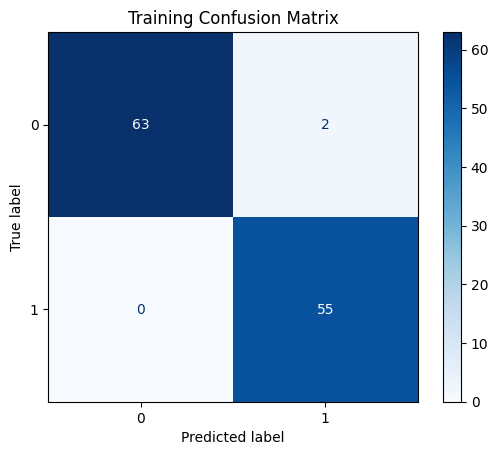

Test Result:
Accuracy       : 0.7333
Precision      : 0.7500
Recall         : 0.5000
F1 Score       : 0.6000

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.89      0.80        18
         1.0       0.75      0.50      0.60        12

    accuracy                           0.73        30
   macro avg       0.74      0.69      0.70        30
weighted avg       0.74      0.73      0.72        30



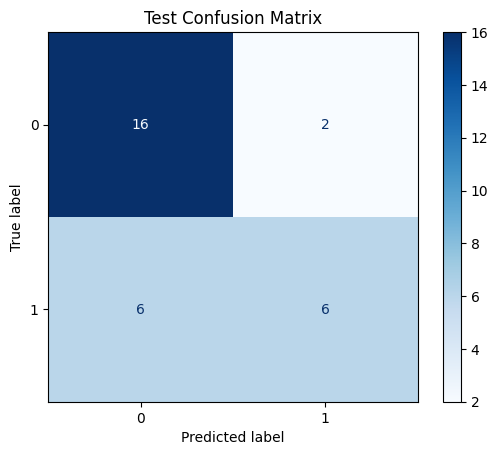

Test Result:
Accuracy       : 0.9333
Precision      : 0.9385
Recall         : 0.9104
F1 Score       : 0.9242

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94        83
         1.0       0.94      0.91      0.92        67

    accuracy                           0.93       150
   macro avg       0.93      0.93      0.93       150
weighted avg       0.93      0.93      0.93       150



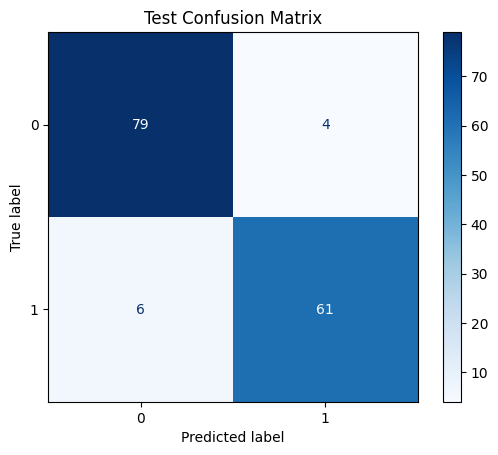

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

param_distributions = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 1, 5, 10],
    'reg_lambda': [1, 1.5, 2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='f1',
    cv=10,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

evaluation(best_model, X_train, y_train, X_test, y_test, train=True)
evaluation(best_model, X_train, y_train, X_test, y_test, train=False)
evaluation(best_model, X_train, y_train, X, y, train=False)


with early stopping

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[0]	validation_0-logloss:0.69432
[1]	validation_0-logloss:0.69432
[2]	validation_0-logloss:0.69432
[3]	validation_0-logloss:0.69432
[4]	validation_0-logloss:0.69432
[5]	validation_0-logloss:0.69432
[6]	validation_0-logloss:0.69432
[7]	validation_0-logloss:0.69432
[8]	validation_0-logloss:0.69432
[9]	validation_0-logloss:0.69432
[0]	validation_0-logloss:0.69784
[1]	validation_0-logloss:0.69784
[2]	validation_0-logloss:0.69784
[3]	validation_0-logloss:0.69784
[4]	validation_0-logloss:0.69784
[5]	validation_0-logloss:0.69762
[6]	validation_0-logloss:0.69762
[7]	validation_0-logloss:0.69762
[8]	validation_0-logloss:0.69762
[9]	validation_0-logloss:0.69762
[10]	validation_0-logloss:0.69762
[11]	validation_0-logloss:0.69762
[12]	validation_0-logloss:0.69762
[13]	validation_0-logloss:0.69762
[14]	validation_0-logloss:0.69762
[0]	validation_0-logloss:0.69432
[1]	validation_0-logloss:0.69432
[2]	validation_0-logloss:0.69432
[0]	valid

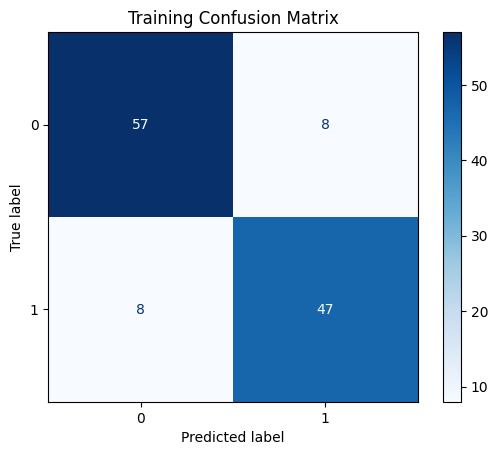

Test Result:
Accuracy       : 0.7000
Precision      : 0.6364
Recall         : 0.5833
F1 Score       : 0.6087

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.78      0.76        18
         1.0       0.64      0.58      0.61        12

    accuracy                           0.70        30
   macro avg       0.69      0.68      0.68        30
weighted avg       0.70      0.70      0.70        30



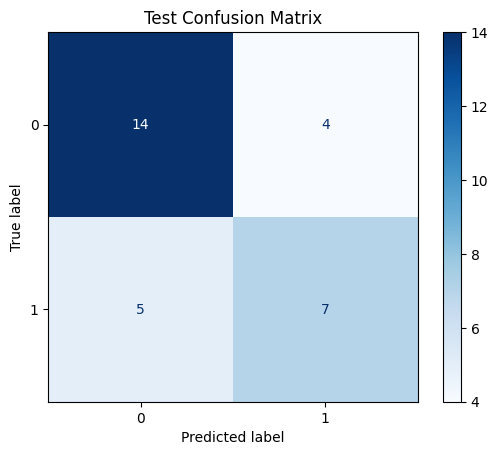

Test Result:
Accuracy       : 0.8333
Precision      : 0.8182
Recall         : 0.8060
F1 Score       : 0.8120

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.85        83
         1.0       0.82      0.81      0.81        67

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



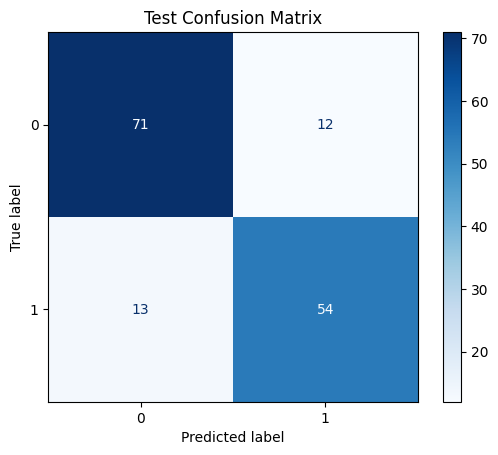

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Calculate scale_pos_weight
neg = 83
pos = 67
scale_pos_weight = neg / pos  # ~1.24

# Split training data further into train/validation for early stopping
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=10
)

param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'reg_alpha': [0, 0.1, 1, 5, 10], 
    'reg_lambda': [1, 1.5, 2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=True
)

best_model = random_search.best_estimator_

# Evaluate on full train and test sets
evaluation(best_model, X_train, y_train, X_test, y_test, train=True)
evaluation(best_model, X_train, y_train, X_test, y_test, train=False)
evaluation(best_model, X_train, y_train, X, y, train=False)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

log_reg = LogisticRegression(
    random_state=42,
    solver='liblinear',
    max_iter=1000,
    class_weight='balanced'
)

param_distributions = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    estimator=log_reg,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_log_reg = random_search.best_estimator_

def evaluation(model, X_train, y_train, X_test, y_test, X, y):
    for split, X, y in [('Train', X_train, y_train), ('Test', X_test, y_test), ('All', X, y)]:
        y_pred = model.predict(X)
        print(f"{split} Results:")
        print("="*40)
        print(f"Accuracy : {accuracy_score(y, y_pred):.4f}")
        print(f"Precision: {precision_score(y, y_pred):.4f}")
        print(f"Recall   : {recall_score(y, y_pred):.4f}")
        print(f"F1 Score : {f1_score(y, y_pred):.4f}")
        print()

evaluation(best_log_reg, X_train, y_train, X_test, y_test, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END .................................C=0.01, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1

with scaling

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42, solver='liblinear', max_iter=1000, class_weight='balanced'))
])

param_distributions = {
    'log_reg__C': [0.01, 0.1, 1, 10, 100],
    'log_reg__penalty': ['l1', 'l2']
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_pipeline = random_search.best_estimator_

# Evaluate on train and test
evaluation(best_pipeline, X_train, y_train, X_test, y_test, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l1; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ...............log_reg__C=0.01, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l1; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l1; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l2; total time=   0.0s
[CV] END ................log_reg__C=0.1, log_reg__penalty=l2; total time=   0.0s
[CV] END ..................log_reg__C=1, log_reg